In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import tensorflow as tf
import edward as ed
from edward.models import MultivariateNormalFullCovariance, MultivariateNormalTriL, Normal
#import distributions
from build_dataset import build_dataset_2dim_ugm

from  visualize_tools import circle, ellipse, covariance_ellipse, change_aspect_ratio

font = {'family': 'serif','color':  'black','weight': 'normal','size': 16,}

In [9]:
def covariance_2dim(params):
    elements = Normal(loc=params[0], scale=params[1])

    tril = tf.exp(elements[0])*[[1.0,0.0],[0.0,0.0]]+tf.exp(elements[1])*[[0.0,0.0],[0.0,1.0]]+elements[2]*[[0.0,0.0],[1.0,0.0]]
    return elements, tril

In [10]:
N=1000
mu_true =[0.0,0.0]
sigma_true = [[2.0,-0.4],[-0.4,1.0]]
x_data=build_dataset_2dim_ugm(N,mean=mu_true,std=sigma_true)

<IPython.core.display.Javascript object>


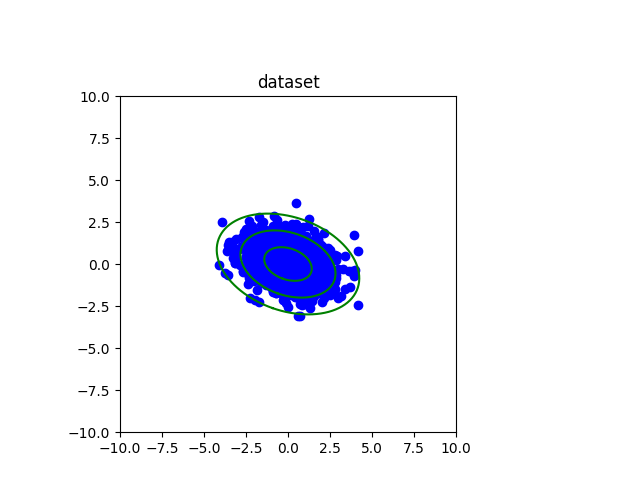

In [11]:
%matplotlib nbagg
fig = plt.figure()

ax = plt.axes([0.1,0.1,0.7,0.7])
ax.set_title("dataset")
ax.set_xlim(-10.0,10.0)
ax.set_ylim(-10.0,10.0)
plt.gca().set_aspect('equal', adjustable='box')
c1,c2,ca=covariance_ellipse(sigma_true)
ex,ey=ellipse(c1,c2,ca)
plt.plot(ex,ey,color="green")
plt.plot(ex*2,ey*2,color="green")
plt.plot(ex*3,ey*3,color="green")
plt.scatter(x_data.T[0],x_data.T[1],color="blue")
#plt.savefig("dataset_ex2.png")
plt.show()

In [26]:
def bbvi_2dim_ugm(N,x_data,n_iter):
    #generative model
    mu = Normal(loc=[0.0,0.0],scale=1.0)
    
    params=[[tf.constant(1.0),tf.constant(1.0),tf.constant(1.0)],tf.nn.softplus(tf.constant(0.5))]
    sigma, Sigma = covariance_2dim(params)

    x = MultivariateNormalTriL(loc=mu,scale_tril=Sigma,sample_shape=N)

    #variational model
    lambda_m = tf.Variable([-3.0,-3.0])
    lambda_s = tf.nn.softplus(tf.Variable(1.5))
    qmu = Normal(loc=lambda_m,scale=lambda_s)

    lambda_m11 = tf.Variable(2.0)

    lambda_m22 = tf.Variable(2.0)

    lambda_m21= tf.Variable(0.0)
    lambda_ss = tf.nn.softplus(tf.Variable(0.5))
    q_params = [[lambda_m11,lambda_m22,lambda_m21],lambda_ss]
    
    qsigma, qSigma = covariance_2dim(q_params)
        
    latent_vars = {mu:qmu,sigma:qsigma}

    data = {x:x_data}
    inference=ed.KLqp(latent_vars=latent_vars,data=data)
    inference.initialize(n_iter=n_iter)
    sess=ed.get_session()
    tf.global_variables_initializer().run()
    loss=[]
    variational_parameter=[]
    variational_parameter.append(sess.run([lambda_m,lambda_s,lambda_m11,lambda_m22,lambda_m21,lambda_ss]))
    for _ in range(inference.n_iter):
        info_dict=inference.update()
        loss.append(info_dict['loss'])
        variational_parameter.append(sess.run([lambda_m,lambda_s,lambda_m11,lambda_m22,lambda_m21,lambda_ss]))
    return loss,variational_parameter

In [27]:
loss,variational_parameter= bbvi_2dim_ugm(N,x_data,2000)

In [22]:
for t,vp in enumerate(variational_parameter):
    print(t,vp[0],vp[1],np.exp(vp[2]),np.exp(vp[3]),vp[4],vp[5])

0 [-3. -3.] 1.70141 20.0855 20.0855 0.0 0.974077
1 [-2.9000001 -2.9000001] 1.62042 18.1741 18.1741 0.1 1.03749
2 [-2.82379675 -2.815624  ] 1.56026 19.4875 16.4526 0.175913 0.991068
3 [-2.76515436 -2.74328256] 1.51412 20.4503 14.8889 0.234743 0.958326
4 [-2.70907784 -2.66849613] 1.47978 21.2466 13.5141 0.306767 0.933431
5 [-2.66127419 -2.59966469] 1.44723 21.8402 12.8163 0.387602 0.912123
6 [-2.61845231 -2.53902292] 1.41925 22.2804 12.0182 0.45828 0.894811
7 [-2.58091784 -2.48400187] 1.39485 22.5681 11.1872 0.520552 0.879309
8 [-2.54726291 -2.4351325 ] 1.37366 22.7275 10.3528 0.575585 0.8651
9 [-2.51728535 -2.3899796 ] 1.35492 22.7695 9.5422 0.624658 0.852159
10 [-2.49046779 -2.34722662] 1.33815 22.7081 8.76951 0.668614 0.838287
11 [-2.46584392 -2.30819082] 1.32276 22.5682 8.03674 0.708407 0.825579
12 [-2.44257498 -2.27130866] 1.30904 22.3607 7.35002 0.745261 0.814935
13 [-2.4215672  -2.22249961] 1.29574 22.0811 6.74856 0.779862 0.804905
14 [-2.40255594 -2.17009282] 1.2836 21.7393 6.193

235 [-0.02897133  0.03497424] 0.252668 1.5318 1.05692 -0.264507 0.189757
236 [-0.02471644  0.03547829] 0.251652 1.53737 1.05503 -0.273524 0.189258
237 [-0.01960866  0.03699636] 0.250724 1.54025 1.05261 -0.281641 0.188807
238 [-0.00456555  0.04219332] 0.24961 1.54759 1.05157 -0.282459 0.188354
239 [ 0.00937156  0.05221501] 0.248228 1.54962 1.05181 -0.285346 0.187921
240 [ 0.01755509  0.05980369] 0.246877 1.54884 1.05055 -0.2891 0.187487
241 [ 0.02361165  0.06717461] 0.245656 1.54768 1.04989 -0.284791 0.187076
242 [ 0.02673038  0.07413949] 0.244527 1.53954 1.0484 -0.282566 0.186646
243 [ 0.03478463  0.08151883] 0.243433 1.53233 1.04637 -0.274047 0.18624
244 [ 0.03147306  0.08277507] 0.242089 1.52701 1.04595 -0.253191 0.185822
245 [ 0.02654007  0.08445833] 0.240865 1.51916 1.0459 -0.232752 0.185436
246 [ 0.01809257  0.0888647 ] 0.239557 1.51035 1.04555 -0.220001 0.185084
247 [ 0.00806727  0.09169679] 0.238366 1.50064 1.04458 -0.203312 0.184748
248 [ 0.0057262   0.09661272] 0.237171 1.5006

383 [ 0.01867565  0.03926649] 0.14366 1.36923 1.02172 -0.171458 0.135341
384 [ 0.01870088  0.04013864] 0.14347 1.36878 1.01728 -0.166477 0.135137
385 [ 0.01612785  0.04058724] 0.143295 1.37258 1.01204 -0.164198 0.134922
386 [ 0.01428844  0.04086325] 0.143137 1.37446 1.00728 -0.163994 0.134729
387 [ 0.01489425  0.0398824 ] 0.142969 1.37299 1.00452 -0.171366 0.13452
388 [ 0.01377832  0.04182065] 0.142758 1.37549 1.00235 -0.181599 0.13432
389 [ 0.01195309  0.04724755] 0.142467 1.37367 1.00091 -0.195208 0.134123
390 [ 0.01542521  0.05361959] 0.142157 1.37775 0.998787 -0.209135 0.133915
391 [ 0.01446175  0.06165669] 0.141816 1.3821 0.99709 -0.230464 0.133717
392 [ 0.01897173  0.07276362] 0.141404 1.39012 0.996643 -0.243225 0.133513
393 [ 0.02520646  0.08523718] 0.14099 1.40335 0.997089 -0.248412 0.133296
394 [ 0.02950703  0.09647273] 0.14062 1.41498 0.99636 -0.254123 0.133086
395 [ 0.0339957   0.10545766] 0.140276 1.4211 0.995119 -0.261216 0.13288
396 [ 0.03600881  0.11163484] 0.139955 1.42

597 [ 0.02756128  0.07802559] 0.100639 1.39983 1.03182 -0.285125 0.0990278
598 [ 0.01599328  0.07509851] 0.100544 1.40412 1.03085 -0.284041 0.0989091
599 [ 0.00629287  0.07036729] 0.100421 1.41188 1.0289 -0.283276 0.0987843
600 [-0.00492284  0.06637479] 0.100306 1.41955 1.02696 -0.281831 0.0986724
601 [-0.01568177  0.06330229] 0.10021 1.42535 1.02473 -0.281581 0.0985801
602 [-0.02476968  0.06007728] 0.100123 1.4268 1.02272 -0.281625 0.0984889
603 [-0.03395271  0.05518748] 0.100019 1.4257 1.02101 -0.285279 0.0984011
604 [-0.03831834  0.05111293] 0.0999102 1.42627 1.02056 -0.284371 0.0983073
605 [-0.04258357  0.04787366] 0.0998122 1.42258 1.01973 -0.283837 0.0982121
606 [-0.04750472  0.04321699] 0.0997106 1.41842 1.02084 -0.280756 0.0980981
607 [-0.05392158  0.03769954] 0.0996063 1.41867 1.02217 -0.276902 0.097983
608 [-0.05868854  0.03534272] 0.0994888 1.41558 1.02478 -0.275576 0.0978562
609 [-0.06269354  0.03248376] 0.0993781 1.41287 1.02617 -0.276647 0.0977337
610 [-0.06753352  0.0296

793 [-0.01623004  0.08893588] 0.0839109 1.36557 0.99022 -0.193183 0.0834229
794 [-0.01933389  0.09118671] 0.0838344 1.36683 0.98856 -0.191396 0.0833497
795 [-0.02335981  0.09266696] 0.0837654 1.3662 0.988105 -0.194541 0.0832732
796 [-0.02709838  0.0928378 ] 0.0836986 1.36372 0.987243 -0.199349 0.0832014
797 [-0.02944279  0.09475706] 0.0836203 1.36479 0.986265 -0.204845 0.0831308
798 [-0.03558938  0.09610606] 0.0835352 1.36802 0.984887 -0.216025 0.083055
799 [-0.04208243  0.09762669] 0.0834574 1.37018 0.984312 -0.224983 0.082983
800 [-0.05146237  0.09892787] 0.0833753 1.37378 0.984073 -0.231437 0.0829161
801 [-0.05963703  0.09827284] 0.0832989 1.37398 0.984362 -0.240189 0.0828539
802 [-0.06374256  0.0991798 ] 0.0832111 1.37367 0.984834 -0.247438 0.0827977
803 [-0.06685726  0.09979301] 0.0831335 1.37222 0.985744 -0.254656 0.0827448
804 [-0.0714786   0.09792048] 0.0830413 1.36936 0.987304 -0.260312 0.082692
805 [-0.07581235  0.09655496] 0.0829582 1.36952 0.989032 -0.266458 0.0826387
806 [

930 [-0.0335956   0.04453121] 0.0765292 1.3854 0.994091 -0.243029 0.0758593
931 [-0.03544988  0.04617871] 0.0764988 1.37807 0.995442 -0.246757 0.0758101
932 [-0.03685433  0.04766282] 0.0764725 1.37198 0.996616 -0.245252 0.0757599
933 [-0.03691308  0.0487601 ] 0.0764479 1.36886 0.997229 -0.242411 0.0757108
934 [-0.03977122  0.04982658] 0.0764162 1.36602 0.997464 -0.237118 0.0756643
935 [-0.04349317  0.04859188] 0.0763671 1.36411 0.998616 -0.23398 0.075616
936 [-0.04746752  0.04771648] 0.0763231 1.36074 0.999556 -0.231208 0.0755712
937 [-0.05006333  0.04775959] 0.076281 1.35848 0.999649 -0.22869 0.0755273
938 [-0.0525674  0.0483951] 0.0762426 1.35718 0.999468 -0.225807 0.0754877
939 [-0.05497457  0.0486889 ] 0.0762083 1.35529 0.998893 -0.222939 0.0754513
940 [-0.0560638   0.04842599] 0.0761753 1.35223 0.998281 -0.222545 0.0754171
941 [-0.055949    0.04715334] 0.0761358 1.35024 0.996877 -0.221646 0.0753812
942 [-0.05545839  0.04593907] 0.0761012 1.34782 0.996296 -0.221445 0.0753453
943 [-

1097 [-0.04003742  0.04921629] 0.0707571 1.36308 0.985386 -0.233532 0.0699292
1098 [-0.04122963  0.04742466] 0.0707143 1.36912 0.985006 -0.239629 0.0698939
1099 [-0.04135004  0.04616464] 0.0706764 1.37877 0.984706 -0.242377 0.0698535
1100 [-0.04016968  0.04663412] 0.0706319 1.38627 0.984285 -0.246849 0.0698159
1101 [-0.03837612  0.04715291] 0.0705965 1.3948 0.98389 -0.247109 0.0697806
1102 [-0.03740945  0.04640226] 0.070557 1.40162 0.983732 -0.244869 0.0697464
1103 [-0.03690338  0.04639047] 0.0705194 1.40654 0.983183 -0.241559 0.0697131
1104 [-0.03744782  0.04634153] 0.0704851 1.40937 0.98235 -0.239004 0.069682
1105 [-0.03606036  0.04723347] 0.0704488 1.41018 0.981334 -0.236136 0.0696522
1106 [-0.03292598  0.0490101 ] 0.0704118 1.41039 0.980678 -0.231975 0.0696245
1107 [-0.02921009  0.05179313] 0.0703739 1.41121 0.980495 -0.230416 0.0695973
1108 [-0.02580195  0.05413656] 0.0703405 1.41112 0.980096 -0.230614 0.0695725
1109 [-0.02192779  0.05621939] 0.0703106 1.41116 0.979571 -0.230442 0

1206 [-0.04505445  0.07105204] 0.0674321 1.43061 0.992079 -0.225437 0.0671752
1207 [-0.04743922  0.06843951] 0.0674025 1.4312 0.991795 -0.234027 0.0671492
1208 [-0.05015425  0.06448653] 0.067364 1.43128 0.991626 -0.243896 0.0671255
1209 [-0.05210958  0.06147996] 0.067329 1.42792 0.992374 -0.252965 0.0670921
1210 [-0.05319422  0.05846881] 0.0672973 1.42401 0.992929 -0.262 0.0670625
1211 [-0.05424228  0.0551606 ] 0.0672674 1.41578 0.992889 -0.271117 0.0670192
1212 [-0.0552352  0.0524745] 0.0672407 1.40757 0.992471 -0.279016 0.0669798
1213 [-0.05372683  0.05056221] 0.0672115 1.39902 0.992089 -0.28551 0.0669439
1214 [-0.05114526  0.04889922] 0.0671848 1.39055 0.991496 -0.293163 0.0669103
1215 [-0.04727412  0.04846783] 0.0671562 1.38435 0.990758 -0.297754 0.0668784
1216 [-0.04440691  0.04762466] 0.0671295 1.37872 0.989827 -0.302971 0.0668491
1217 [-0.04307702  0.04632243] 0.0671027 1.37327 0.988742 -0.30674 0.0668228
1218 [-0.0415457   0.04532983] 0.0670796 1.36748 0.987489 -0.30763 0.06679

1454 [-0.01545316  0.05090778] 0.0616403 1.37402 0.991221 -0.23968 0.0615215
1455 [-0.0171601   0.05162586] 0.0616284 1.37247 0.990945 -0.240158 0.0615011
1456 [-0.01891061  0.05231248] 0.0616185 1.3712 0.99056 -0.239554 0.0614826
1457 [-0.02041337  0.05387906] 0.0616058 1.37026 0.989889 -0.238537 0.0614655
1458 [-0.0213281   0.05536891] 0.0615948 1.3699 0.988978 -0.237878 0.0614498
1459 [-0.02326707  0.05664076] 0.0615845 1.37144 0.987638 -0.239117 0.0614308
1460 [-0.02559435  0.05694688] 0.0615724 1.3718 0.986507 -0.239543 0.0614128
1461 [-0.02759332  0.05763625] 0.0615616 1.37248 0.985757 -0.241789 0.0613956
1462 [-0.03044652  0.05765748] 0.06155 1.37405 0.984995 -0.243599 0.0613796
1463 [-0.03414748  0.05709958] 0.0615377 1.37519 0.984168 -0.243779 0.0613647
1464 [-0.03656321  0.05713753] 0.0615256 1.37515 0.983311 -0.244798 0.0613509
1465 [-0.03847613  0.05685884] 0.0615147 1.37789 0.982616 -0.243114 0.0613335
1466 [-0.04047681  0.05558135] 0.0614987 1.37907 0.981634 -0.239682 0.0

1596 [-0.01175334  0.06390188] 0.0596364 1.35787 0.975293 -0.279137 0.0589128
1597 [-0.00840038  0.06474574] 0.059622 1.3595 0.975654 -0.278919 0.0588934
1598 [-0.00572131  0.06555885] 0.0596097 1.36147 0.975816 -0.276231 0.0588744
1599 [-0.00384792  0.06640109] 0.0595991 1.36246 0.976275 -0.273636 0.0588564
1600 [-0.0027405   0.06730308] 0.05959 1.36255 0.977593 -0.272153 0.0588347
1601 [-0.00212171  0.06770817] 0.0595828 1.36356 0.978675 -0.269351 0.0588165
1602 [-0.00288381  0.06790992] 0.0595756 1.36542 0.979765 -0.265414 0.0587995
1603 [-0.00433508  0.06874634] 0.0595662 1.36643 0.981218 -0.262127 0.0587824
1604 [-0.00519791  0.06927139] 0.0595575 1.36614 0.982689 -0.259376 0.058766
1605 [-0.00550323  0.06953729] 0.0595495 1.36566 0.983896 -0.256177 0.0587513
1606 [-0.00584392  0.070895  ] 0.0595338 1.36673 0.984676 -0.251576 0.0587353
1607 [-0.00653348  0.07211667] 0.0595202 1.36887 0.98509 -0.246883 0.0587197
1608 [-0.00611294  0.073392  ] 0.0595069 1.37041 0.985586 -0.24213 0.0

1807 [-0.0184265   0.06839835] 0.0574383 1.34355 0.972009 -0.272821 0.0561175
1808 [-0.01889899  0.07021397] 0.0574283 1.34263 0.972138 -0.274204 0.0561086
1809 [-0.01999532  0.07201535] 0.0574187 1.342 0.972147 -0.27458 0.0561005
1810 [-0.01979791  0.07418935] 0.0574073 1.34256 0.971803 -0.274786 0.0560916
1811 [-0.02052189  0.07557045] 0.0573957 1.34288 0.971765 -0.27423 0.0560831
1812 [-0.02182811  0.07670692] 0.0573854 1.34425 0.97129 -0.273246 0.0560733
1813 [-0.02384864  0.07740959] 0.0573758 1.3467 0.970997 -0.271502 0.0560638
1814 [-0.02582918  0.07786451] 0.0573679 1.35036 0.970224 -0.269589 0.0560517
1815 [-0.02790279  0.07815661] 0.0573611 1.35436 0.969787 -0.266906 0.0560401
1816 [-0.02964163  0.07797088] 0.0573547 1.35936 0.969649 -0.264141 0.0560284
1817 [-0.03055622  0.07782805] 0.0573488 1.36278 0.969531 -0.262823 0.0560163
1818 [-0.03073517  0.07893838] 0.0573362 1.36525 0.96998 -0.262427 0.0560033
1819 [-0.03124424  0.08029521] 0.0573242 1.36765 0.97083 -0.262838 0.05

1953 [-0.02300278  0.07300518] 0.0560257 1.34607 0.966051 -0.234666 0.0544737
1954 [-0.02258257  0.07340515] 0.0560077 1.34615 0.96484 -0.236411 0.0544647
1955 [-0.02226723  0.07351392] 0.0559921 1.34731 0.964088 -0.23664 0.054455
1956 [-0.02150476  0.07367609] 0.055978 1.34795 0.963737 -0.236101 0.0544452
1957 [-0.02143697  0.07341906] 0.055965 1.34878 0.963471 -0.235847 0.0544365
1958 [-0.02072708  0.07389977] 0.0559507 1.34801 0.96362 -0.236136 0.0544257
1959 [-0.02051826  0.07414395] 0.0559382 1.34834 0.964243 -0.236332 0.0544139
1960 [-0.01947575  0.07435305] 0.0559263 1.34907 0.965014 -0.237121 0.0544031
1961 [-0.01855283  0.07484199] 0.0559158 1.34941 0.965944 -0.237409 0.0543929
1962 [-0.01763776  0.07477028] 0.0559052 1.34864 0.966747 -0.238535 0.0543827
1963 [-0.01629307  0.07437208] 0.0558949 1.34927 0.967679 -0.238199 0.054372
1964 [-0.0158575   0.07390872] 0.0558855 1.34969 0.968093 -0.238013 0.0543608
1965 [-0.01567424  0.07287242] 0.0558756 1.35 0.968349 -0.238025 0.0543

<IPython.core.display.Javascript object>


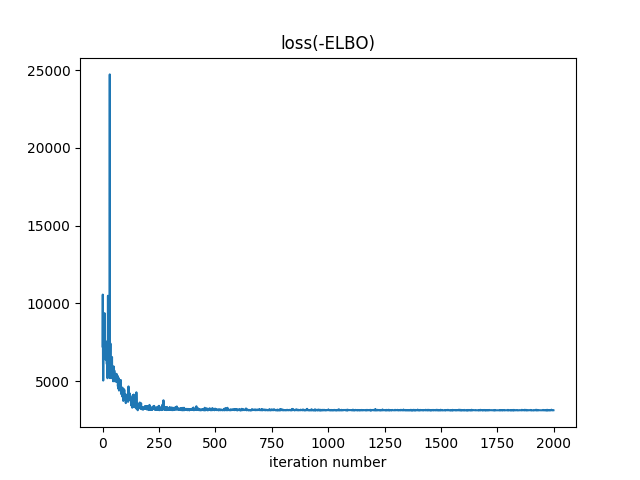

In [23]:
%matplotlib nbagg
plt.title("loss(-ELBO)")
plt.plot(loss)
plt.xlabel("iteration number")
plt.show()

<IPython.core.display.Javascript object>


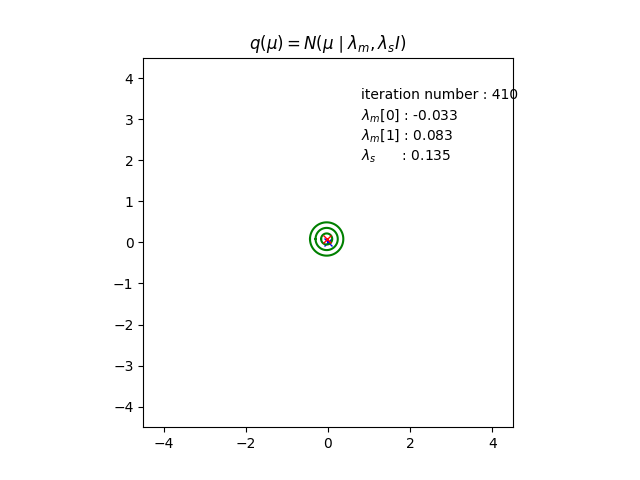

In [24]:
%matplotlib nbagg
fig = plt.figure()
ax = plt.axes()
change_aspect_ratio(ax,1.0)
artists = []
plt.title("$q(\mu)=N(\mu\mid\lambda_m,\lambda_s I)$")
plt.xlim(-4.5,4.5)
plt.ylim(-4.5,4.5)
plt.plot(mu_true[0],mu_true[1],'bx')
for t,vp in enumerate(variational_parameter):
    if t % 10 == 0 and t < 1000:
        x,y=circle(vp[0][0],vp[0][1],vp[1])
        c1=plt.plot(x,y,color="green")
        x,y=circle(vp[0][0],vp[0][1],vp[1]*2)
        c2=plt.plot(x,y,color="green")
        x,y=circle(vp[0][0],vp[0][1],vp[1]*3)
        c3=plt.plot(x,y,color="green")
        i_mu = plt.plot(vp[0][0],vp[0][1],'rx')
        text = [plt.text(0.8,3.5,"iteration number : "+str(t)),
                     plt.text(0.8,3.0,"$\lambda_m$[0] : {0:.3f}".format(vp[0][0])),
                     plt.text(0.8,2.5,"$\lambda_m$[1] : {0:.3f}".format(vp[0][1])),
                     plt.text(0.8,2.0,"$\lambda_s$      : {0:.3f}".format(vp[1]))]
        artists.append(c1+c2+c3+i_mu+text)

ani = animation.ArtistAnimation(fig,artists)
#ani.save("mu_ex2.gif", writer='imagemagick', fps=4)
plt.show()

<IPython.core.display.Javascript object>


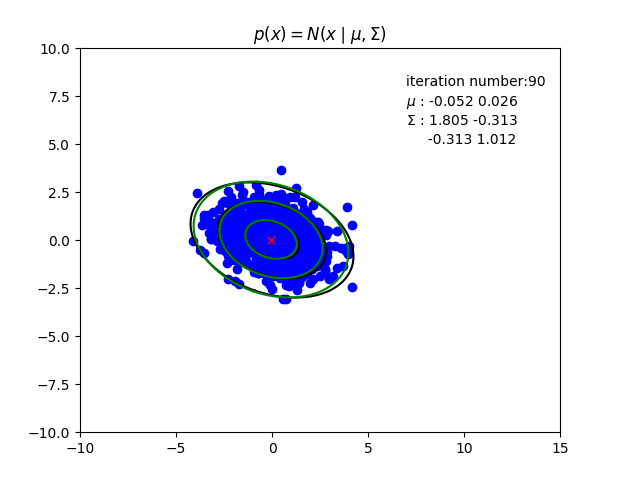

In [28]:
%matplotlib nbagg
fig = plt.figure()
ax = plt.axes([0.1,0.1,0.8,0.8])
ax.set_title("$p(x)=N(x\mid \mu,\Sigma)$")
ax.set_xlim(-10.0,15.0)
ax.set_ylim(-10.0,10.0)
plt.gca().set_aspect('equal', adjustable='box')
artists= []
for n,x in enumerate(x_data):
    plt.scatter(x[0],x[1],color="blue")
c1,c2,ca=covariance_ellipse(sigma_true)
ex,ey=ellipse(c1,c2,ca)
plt.plot(ex,ey,color="black")
plt.plot(ex*2,ey*2,color="black")
plt.plot(ex*3,ey*3,color="black")

for t,vp in enumerate(variational_parameter):
    if t%10==0 and t<1000:
        l11=np.exp(vp[2])
        l22=np.exp(vp[3])
        l21=vp[4]
        L= l11*np.array([[1.0,0.0],[0.0,0.0]])+l22*np.array([[0.0,0.0],[0.0,1.0]])+l21*np.array([[0.0,0.0],[1.0,0.0]])
        cov = np.dot(L,L.T)
        c1,c2,ca=covariance_ellipse(cov)
        ex,ey=ellipse(c1,c2,ca)
        e1=plt.plot(ex+vp[0][0],ey+vp[0][1],color="green")
        e2=plt.plot(ex*2+vp[0][0],ey*2+vp[0][1],color="green")
        e3=plt.plot(ex*3+vp[0][0],ey*3+vp[0][1],color="green")
        point=plt.plot(vp[0][0],vp[0][1],'rx')
        text = [plt.text(7.0,8.0,"iteration number:"+str(t)),
                     plt.text(7.0,7.0,"$\mu$ : " + "{0:.3f} ".format(vp[0][0]) +"{0:.3f}".format(vp[0][1])),
                     plt.text(7.0,6.0,"$\Sigma$ : "+"{0:.3f} ".format(cov[0][0]) +"{0:.3f}".format(cov[0][1])),
                     plt.text(7.0,5.0,"     "+"{0:.3f} ".format(cov[1][0]) +"{0:.3f}".format(cov[1][1]))]
        artists.append(e1+e2+e3+point+text)
ani = animation.ArtistAnimation(fig, artists)
#ani.save("result_ex2.gif", writer='imagemagick', fps=4)
plt.show()